# Homework 1

We are going to work with the following dataset: fluid current in a tube. Some statistics are collected for dataset, incl. mean, skewness, kurtosis, etc. We are predicting flow rate ('tohn/hour'). We need to build confidence and predictive intervals.

In [1]:
%matplotlib inline

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model, preprocessing, model_selection
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats as st
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [2]:
df = pd.read_csv('exxsol_data.csv', sep=';', header=(0))

There are 10 features and 1 label to predict:

In [3]:
print(df.columns.values)

['mean' 'std' 'skew' 'kurt' 'RMS' 'crest' 'freq_peak' 'shan' 'perm' 'temp'
 'tohn/hour']


In [4]:
y = df['tohn/hour']
freq_temp = df[['freq_peak','temp']]

Physics tells us that flow rate is a function of a frequency peak and temperature.

In [5]:
freq_temp, y = shuffle(freq_temp, y, random_state=42)

lr = linear_model.LinearRegression()
predicted = model_selection.cross_val_predict(
    lr, freq_temp, y.ravel(), cv=20)
score = model_selection.cross_val_score(lr, freq_temp, y,
                                         scoring='r2',cv=20)

# Q0: Build point estimate for mean r2 score and its deviation

In [6]:
X_mean = np.mean(score)
S_X = np.var(score, ddof=1)

X_mean, S_X

(0.8258840976744921, 0.003246200198990101)

# Q1: Predicted is an array with predictions of the label y. Assuming, that $\sigma = 0.1$,
# compute 95% confidence and predictive interval for mean squared error.

In [12]:
squared_error = np.sqrt((y - predicted)**2)

n = len(squared_error)
mean_se = np.mean(squared_error)
var_se = 0.1

confidence_int = _zconfint_generic(mean_se, var_se, 0.05, 'two-sided')
predictive_int = _zconfint_generic(mean_se, var_se*(1+1/n), 0.05, 'two-sided')

confidence_int, predictive_int

((0.12558593091531794, 0.5175787278233288),
 (0.12530593606038365, 0.517858722678263))

# Q2: Compute 95% confidence and predicted intervals for mean squared error, assuming no knowledge about $\sigma$.

In [13]:
var_se = np.var(squared_error, ddof=1)

confidence_int = _tconfint_generic(mean_se, np.sqrt(var_se), n - 1, 0.05, 'two-sided')
predictive_int = _tconfint_generic(mean_se, np.sqrt(var_se)*(1+1/n), n -1, 0.05, 'two-sided')

print(f"confidence_int = {confidence_int}, predictive_int = {predictive_int}")

confidence_int = (-0.1579417361131485, 0.8011063948517951), predictive_int = (-0.15862677049240914, 0.8017914292310558)


We can use additional features and more complex model, e.g. ElasticNet.

In [14]:
y = df['tohn/hour']
X = df.drop(['tohn/hour'],axis=1)
X = preprocessing.scale(X)
X, y = shuffle(X, y, random_state=42)

encv = linear_model.ElasticNetCV(cv=10,max_iter=3000, n_alphas=10)
predicted_encv = model_selection.cross_val_predict(
    encv, X, y.ravel(), cv=20)
score_encv = model_selection.cross_val_score(encv,X, y.ravel(),
                                         scoring='r2',cv=20)

# Q3: Compute 95% confidence interval for difference in means of mean squared error between 2 models, assuming no knowledge about $\sigma$.

In [18]:
squared_error_encv = np.sqrt((y - predicted_encv)**2)
n, m = len(squared_error), len(squared_error_encv)
X_mean, Y_mean = np.mean(squared_error), np.mean(squared_error_encv)
S_X, S_Y = np.var(squared_error, ddof=1), np.var(squared_error_encv, ddof=1)
S_P = ((n-1) * S_X + (m-1) * S_Y) / (n + m - 2)


_tconfint_generic(X_mean - Y_mean, 
                  np.sqrt(S_P), n + m - 2, 0.05, 'two-sided')

(-0.2663410203302803, 0.567207950813794)

# Q4: Implement UCB1

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta


class Model:
    def __init__(self, probability, init_mean=0):
        self.probability = probability
        self.mean = init_mean
        if init_mean > 0:
             self.sample_size = 1
        else:
             self.sample_size = 0
    
    def execute(self):
        return np.random.uniform(0,1) < self.probability

    def update(self, x):
        self.sample_size += 1
        self.mean = ((self.sample_size - 1)*self.mean + x) / self.sample_size

def experiment(model_probs, eps, total=1000):
    models = [Model(p, init_mean=1) for p in model_probs]
    rewards = np.zeros(total)

    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0

    optimal_j = np.argmax([m.probability for m in models])
    print("optimal j:", optimal_j)

    for i in range(total):

      # use epsilon-greedy to select the best
      if np.random.uniform(0,1) < eps:
        num_times_explored += 1
        j = np.random.randint(len(models))
      else:
        num_times_exploited += 1
        j = np.argmax([m.mean + np.sqrt(2*np.log(i)/m.sample_size) for m in models])

      if j == optimal_j:
        num_optimal += 1

      # execute best model
      x = models[j].execute()

      # update rewards 
      rewards[i] = x

      # update the distribution for the executed model
      models[j].update(x)
      
    for m in models:
      print("mean estimate:", m.mean)

    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / total)
    print("num_times_explored:", num_times_explored)
    print("num_times_exploited:", num_times_exploited)
    print("num times selected optimal bandit:", num_optimal)

    # plot the results
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(total) + 1)
    plt.plot(win_rates)
    plt.plot(np.ones(total)*np.max(model_probs))
    plt.show()

optimal j: 2


<ipython-input-19-af3bf4834ba6>:41: RuntimeWarning: divide by zero encountered in log
  j = np.argmax([m.mean + np.sqrt(2*np.log(i)/m.sample_size) for m in models])
<ipython-input-19-af3bf4834ba6>:41: RuntimeWarning: invalid value encountered in sqrt
  j = np.argmax([m.mean + np.sqrt(2*np.log(i)/m.sample_size) for m in models])


mean estimate: 0.1986301369863014
mean estimate: 0.4817012858555885
mean estimate: 0.7597239648682553
total reward earned: 6742.0
overall win rate: 0.6742
num_times_explored: 3022
num_times_exploited: 6978
num times selected optimal bandit: 7969


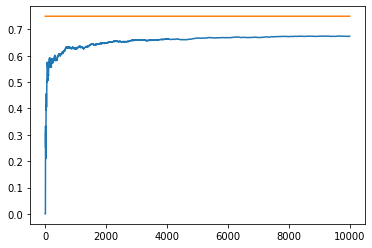

In [21]:
total = 10000
eps = 0.3
model_probs = [0.2, 0.5, 0.75]
experiment(model_probs, eps, total)